## homework no: hw4
## Your name:    仙洞田咲           student ID: 1100452
### When you use code, either from another student or an outside source, you should cite it. Tell me where the code comes from. 
#### ( v  )  1. I totally write by myself (都自己寫)
#### (    ) 2. other students (參考同學,註明姓名學號):   name and student id 
#### (    ) 3. outside source (參考外部資料網站), where:
### If you choose 2 or 3, please tell me the degree of copy. (如果選2,3, 請勾選copy程度)
#### (  ) < 25%      (  )  25%..50%     (   ) 50%..75%        (    ) > 75%
### Give me grade (期望分數): 100
### Reasons (理由): 都是有自己按照上課中教授教來完成的程式，並完全符合應有的output。
## Note that (留意底下檔案命名規格)
The filename is like this hw4_1071234.ipynb, all lower case letters, and no prefix 's' to your student ID. If homework contains only one notebook file, just upload ipynb file, do not compress ipynb file. 

If your homework contains multiple files, compress them and upload. The compressed filename should be like this hw4_1071234.zip.

In [105]:
# For tips on running notebooks in Google Colab, see
# https://pytorch.org/tutorials/beginner/colab
%matplotlib inline

[Learn the Basics](intro.html) \|\| **Quickstart** \|\|
[Tensors](tensorqs_tutorial.html) \|\| [Datasets &
DataLoaders](data_tutorial.html) \|\|
[Transforms](transforms_tutorial.html) \|\| [Build
Model](buildmodel_tutorial.html) \|\|
[Autograd](autogradqs_tutorial.html) \|\|
[Optimization](optimization_tutorial.html) \|\| [Save & Load
Model](saveloadrun_tutorial.html)

Quickstart
==========

This section runs through the API for common tasks in machine learning.
Refer to the links in each section to dive deeper.

Working with data
-----------------

PyTorch has two [primitives to work with
data](https://pytorch.org/docs/stable/data.html):
`torch.utils.data.DataLoader` and `torch.utils.data.Dataset`. `Dataset`
stores the samples and their corresponding labels, and `DataLoader`
wraps an iterable around the `Dataset`.


In [118]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

PyTorch offers domain-specific libraries such as
[TorchText](https://pytorch.org/text/stable/index.html),
[TorchVision](https://pytorch.org/vision/stable/index.html), and
[TorchAudio](https://pytorch.org/audio/stable/index.html), all of which
include datasets. For this tutorial, we will be using a TorchVision
dataset.

The `torchvision.datasets` module contains `Dataset` objects for many
real-world vision data like CIFAR, COCO ([full list
here](https://pytorch.org/vision/stable/datasets.html)). In this
tutorial, we use the FashionMNIST dataset. Every TorchVision `Dataset`
includes two arguments: `transform` and `target_transform` to modify the
samples and labels respectively.


In [119]:
# Download training data from open datasets.
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

We pass the `Dataset` as an argument to `DataLoader`. This wraps an
iterable over our dataset, and supports automatic batching, sampling,
shuffling and multiprocess data loading. Here we define a batch size of
64, i.e. each element in the dataloader iterable will return a batch of
64 features and labels.


In [120]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


Read more about [loading data in PyTorch](data_tutorial.html).


------------------------------------------------------------------------


Creating Models
===============

To define a neural network in PyTorch, we create a class that inherits
from
[nn.Module](https://pytorch.org/docs/stable/generated/torch.nn.Module.html).
We define the layers of the network in the `__init__` function and
specify how data will pass through the network in the `forward`
function. To accelerate operations in the neural network, we move it to
the GPU or MPS if available.


In [121]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

Using cpu device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


Read more about [building neural networks in
PyTorch](buildmodel_tutorial.html).


------------------------------------------------------------------------


Optimizing the Model Parameters
===============================

To train a model, we need a [loss
function](https://pytorch.org/docs/stable/nn.html#loss-functions) and an
[optimizer](https://pytorch.org/docs/stable/optim.html).


In [126]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2)

In a single training loop, the model makes predictions on the training
dataset (fed to it in batches), and backpropagates the prediction error
to adjust the model\'s parameters.


In [1]:
train_loss_lst=[]
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.train()
    train_loss, correct = 0.0, 0.0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        train_loss += loss.item()
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    train_loss /= num_batches
    correct /= size
    train_loss_lst.append(train_loss)
    print(f"Train Error: \n Accuracy: {(100*correct):.1f}%, Avg loss: {train_loss:.6f}")

We also check the model\'s performance against the test dataset to
ensure it is learning.


In [128]:
test_loss_lst=[]
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    test_loss_lst.append(test_loss)
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

The training process is conducted over several iterations (*epochs*).
During each epoch, the model learns parameters to make better
predictions. We print the model\'s accuracy and loss at each epoch;
we\'d like to see the accuracy increase and the loss decrease with every
epoch.


In [129]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
Train Error: 
 Accuracy: 61.7%, Avg loss: 1.253033
Test Error: 
 Accuracy: 71.5%, Avg loss: 0.787576 

Epoch 2
-------------------------------
Train Error: 
 Accuracy: 75.8%, Avg loss: 0.681236
Test Error: 
 Accuracy: 78.0%, Avg loss: 0.630271 

Epoch 3
-------------------------------
Train Error: 
 Accuracy: 80.4%, Avg loss: 0.569616
Test Error: 
 Accuracy: 80.1%, Avg loss: 0.567996 

Epoch 4
-------------------------------
Train Error: 
 Accuracy: 82.2%, Avg loss: 0.515537
Test Error: 
 Accuracy: 80.8%, Avg loss: 0.538086 

Epoch 5
-------------------------------
Train Error: 
 Accuracy: 83.1%, Avg loss: 0.484897
Test Error: 
 Accuracy: 81.3%, Avg loss: 0.518363 

Done!


Read more about [Training your model](optimization_tutorial.html).


------------------------------------------------------------------------


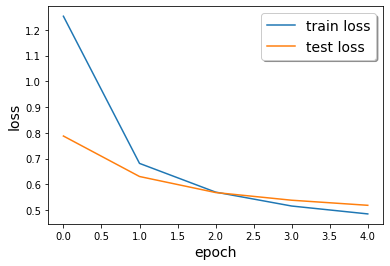

In [131]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True' 
import matplotlib.pyplot as plt 
fig, ax = plt.subplots(figsize=(6, 4)) 
plt.plot(train_loss_lst, label='train loss') 
plt.plot(test_loss_lst, label='test loss') 
ax.set_xlabel('epoch', fontsize=14) 
ax.set_ylabel('loss', fontsize=14) 
legend = ax.legend(loc='upper right', shadow=True, fontsize=14) 


Saving Models
=============

A common way to save a model is to serialize the internal state
dictionary (containing the model parameters).


In [115]:
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


Loading Models
==============

The process for loading a model includes re-creating the model structure
and loading the state dictionary into it.


In [116]:
model = NeuralNetwork().to(device)
model.load_state_dict(torch.load("model.pth"))

<All keys matched successfully>

This model can now be used to make predictions.


In [117]:
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

model.eval()
x, y = test_data[0][0], test_data[0][1]
with torch.no_grad():
    x = x.to(device)
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "Ankle boot", Actual: "Ankle boot"


Read more about [Saving & Loading your
model](saveloadrun_tutorial.html).
